In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt

from data.dataLoader import ClientPreprocessTrain, ClientPreprocessTest, GlobalPreprocess
from data.distribution import data_label_distribution
from globle.trainer.trainer import GlobalTrainer
from globle.trainer.evaluator import GlobalEvaluator
from client.trainer.trainer import ClientTrainer
from client.trainer.evaluator import ClientEvaluator
from models.models import model
from configs.confLoader import *

100%|██████████| 170498071/170498071 [04:37<00:00, 614332.47it/s] 


Extracting data/cifar-10-python.tar.gz to data/
digits	count
Airplane:	1
Automobile:	1
Bird:	3
Cat:	3
Deer:	1
Dog:	2
Frog:	1
Horse:	2
Ship:	1
Truck:	1
torch.Size([16, 3, 32, 32])


C:\Users\MAADUR~1\AppData\Local\Temp/ipykernel_17792/174204973.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(data[i].T)


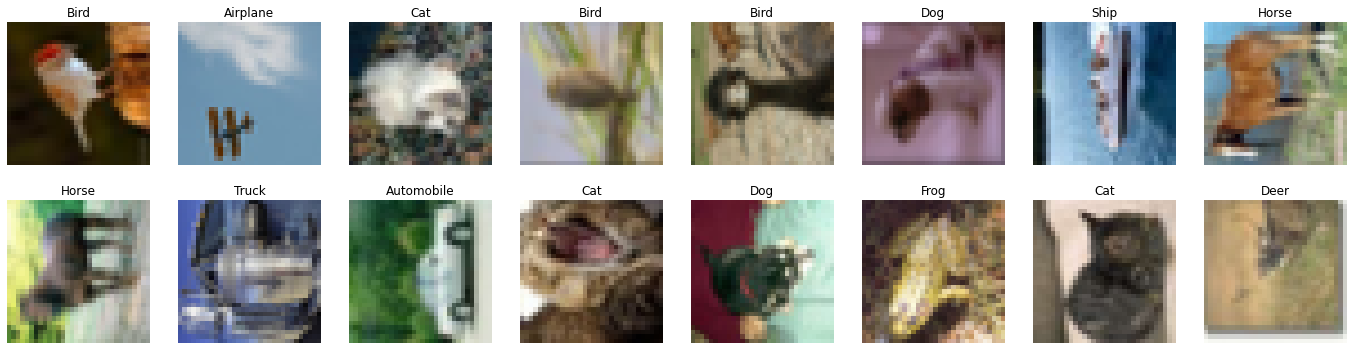

In [2]:
label_dict = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat',
              4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}

client_test = ClientPreprocessTest()
data, target = next(iter(client_test[0]))
label_count = (torch.unique(target, return_counts=True))
print('digits\tcount')
for label, count in zip(label_count[0], label_count[1]):
    print(label_dict[int(label)], ':\t', int(count), sep='')
print(data.shape)
fig = plt.figure(figsize=(24, 6))
for i in range(len(target)):
    fig.add_subplot(2, 8, (i+1))
    plt.imshow(data[i].T)
    plt.axis('off')
    plt.title(label_dict[int(target[i])])


In [3]:
global_model = model
print(global_model)

CNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=512, out_features=10, bias=True)
  )
)


# FedAvg Implemntation for CIFAR NON-IID

In [4]:
global_trainer = GlobalTrainer(global_model, fed_learn_method = 'fedavg')

Files already downloaded and verified


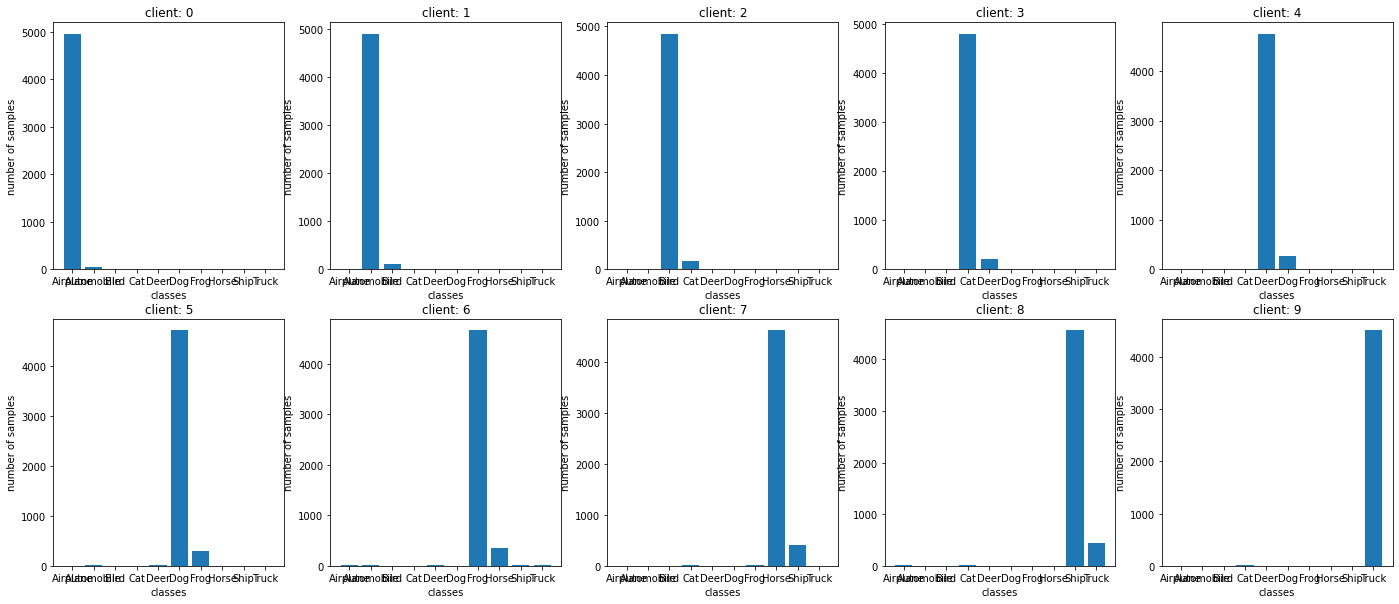

In [5]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    distribution = data_label_distribution(global_trainer.trainset[i])
    plt.bar([label_dict[i] for i in distribution.keys()], distribution.values())
    plt.title(f'client: {i}')
    plt.xlabel('classes')
    plt.ylabel('number of samples')


In [6]:
global_trainer.train()

global_training_epoch: 100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


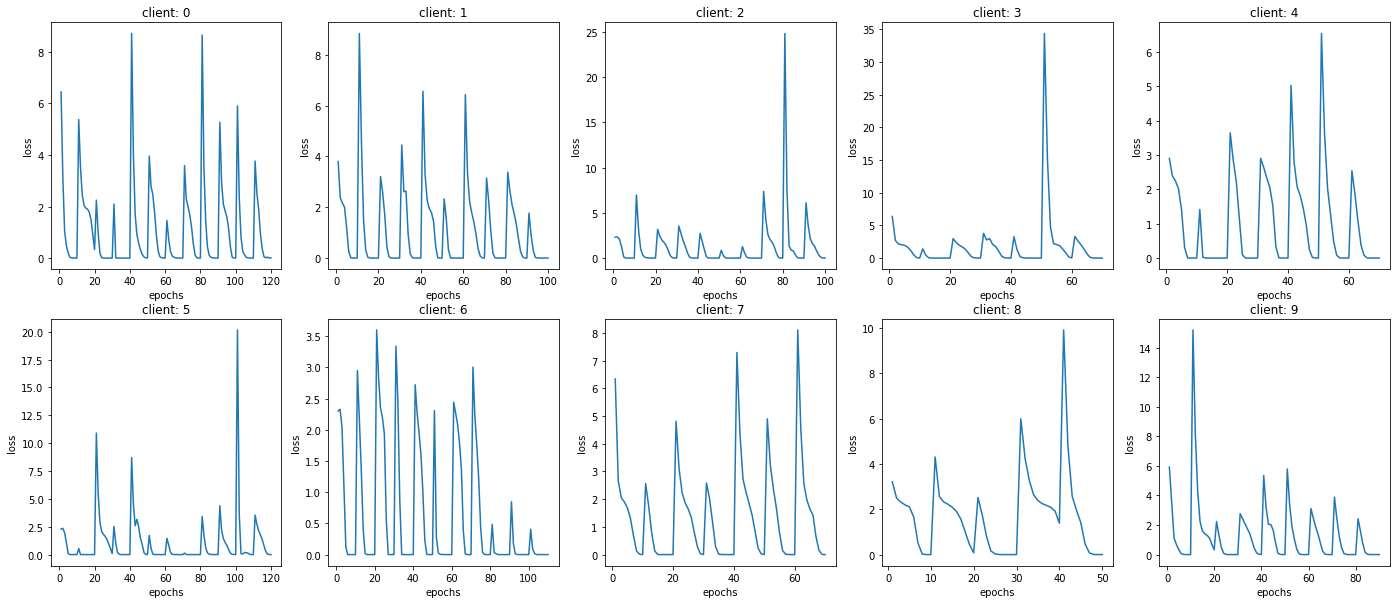

In [7]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    X = global_trainer.client_trainer_set[i].loss_history
    Y = [i+1 for i in range(len(X))]
    plt.plot(Y, X)
    plt.title(f'client: {i}')
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [8]:
global_test = GlobalPreprocess()

client_evaluator_set = [ClientEvaluator(i, global_model, client_test[i]) for i in range(n_clients)]
global_evaluator = GlobalEvaluator(global_model, global_test)

Files already downloaded and verified


In [9]:
avg_client_acc = 0
avg_client_loss = 0
avg_client_conf_mat = torch.zeros([10, 10])  
  
for i in range(n_clients):
    client_evaluator_set[i].test()
    avg_client_acc += client_evaluator_set[i].accuracy
    avg_client_loss += client_evaluator_set[i].loss
    print(type(client_evaluator_set[i].conf_mat), type(avg_client_conf_mat))
    avg_client_conf_mat = torch.add(avg_client_conf_mat, client_evaluator_set[i].conf_mat)
    
avg_client_acc /= n_clients
avg_client_loss /= n_clients
avg_client_conf_mat  = torch.div(avg_client_conf_mat, n_clients)
    

client [0]: 100%|██████████| 66/66 [00:01<00:00, 59.48it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [1]: 100%|██████████| 66/66 [00:01<00:00, 41.92it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [2]: 100%|██████████| 66/66 [00:01<00:00, 50.64it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [3]: 100%|██████████| 66/66 [00:01<00:00, 55.28it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [4]: 100%|██████████| 66/66 [00:01<00:00, 54.59it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [5]: 100%|██████████| 66/66 [00:01<00:00, 56.86it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [6]: 100%|██████████| 66/66 [00:01<00:00, 53.31it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [7]: 100%|██████████| 66/66 [00:01<00:00, 51.50it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [8]: 100%|██████████| 66/66 [00:01<00:00, 57.57it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [9]: 100%|██████████| 35/35 [00:00<00:00, 49.49it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>


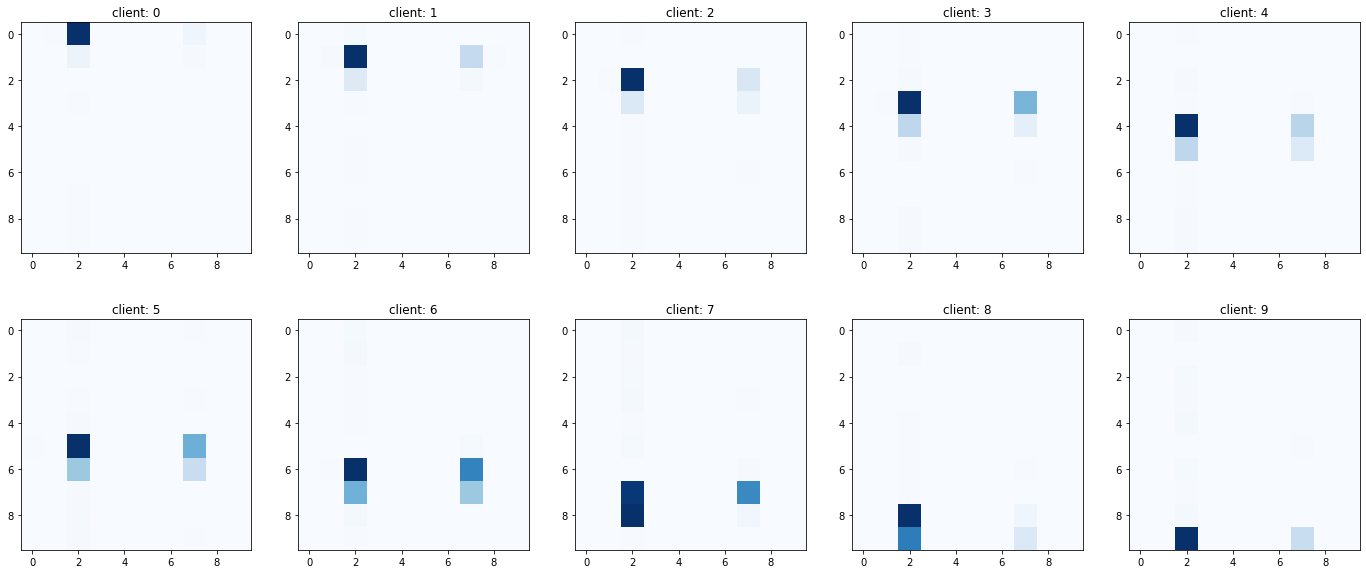

In [10]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    plt.imshow(client_evaluator_set[i].conf_mat, cmap='Blues')
    plt.title(f'client: {i}')


<BarContainer object of 10 artists>

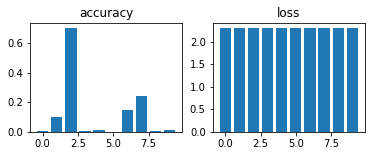

In [11]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].accuracy for i in range(n_clients)])
plt.title('accuracy')
fig.add_subplot(1, 2, 2)
plt.title('loss')   
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].loss for i in range(n_clients)])


In [12]:
global_evaluator.test()

global_evaluation: 100%|██████████| 157/157 [00:09<00:00, 15.85it/s]


Text(0.5, 1.0, 'clieint average')

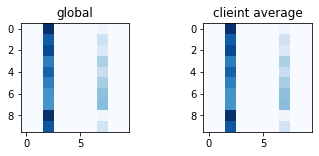

In [13]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.imshow(global_evaluator.conf_mat, cmap='Blues')
plt.title('global')
fig.add_subplot(1, 2, 2)
plt.imshow(avg_client_conf_mat, cmap='Blues')
plt.title('clieint average')


In [14]:
print('Global Accuracy', global_evaluator.accuracy, '\tClient avg Accuracy', avg_client_acc)
print('Global Loss' , global_evaluator.loss, '\tClient avg Loss', avg_client_loss)

Global Accuracy 0.1285828025477707 	Client avg Accuracy 0.12273809523809523
Global Loss 2.30258509299404 	Client avg Loss 2.302585092994046


# FedAvgM Implementation for CIFAR Non_IID

In [15]:
global_trainer = GlobalTrainer(global_model, fed_learn_method = 'fedavgM')

Files already downloaded and verified


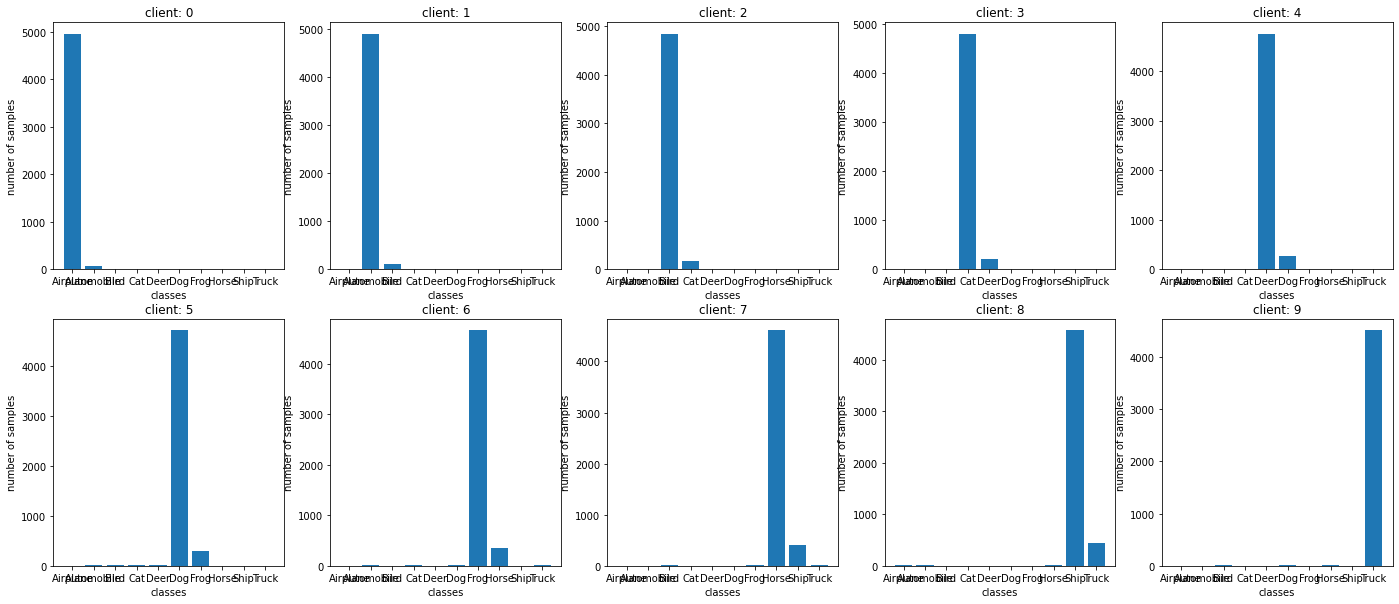

In [16]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    distribution = data_label_distribution(global_trainer.trainset[i])
    plt.bar([label_dict[i] for i in distribution.keys()], distribution.values())
    plt.title(f'client: {i}')
    plt.xlabel('classes')
    plt.ylabel('number of samples')


In [17]:
global_trainer.train()

global_training_epoch: 100%|██████████| 30/30 [01:25<00:00,  2.86s/it]


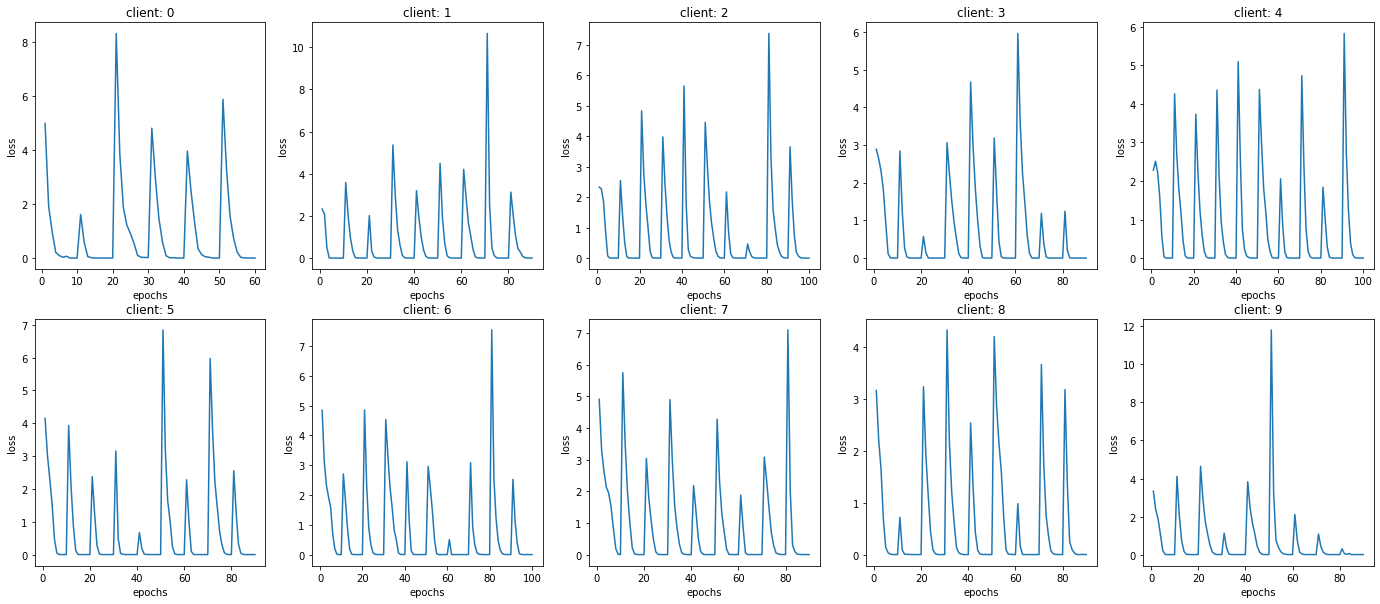

In [18]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    X = global_trainer.client_trainer_set[i].loss_history
    Y = [i+1 for i in range(len(X))]
    plt.plot(Y, X)
    plt.title(f'client: {i}')
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [19]:
global_test = GlobalPreprocess()

client_evaluator_set = [ClientEvaluator(i, global_model, client_test[i]) for i in range(n_clients)]
global_evaluator = GlobalEvaluator(global_model, global_test)

Files already downloaded and verified


In [20]:
avg_client_acc = 0
avg_client_loss = 0
avg_client_conf_mat = torch.zeros([10, 10])  
  
for i in range(n_clients):
    client_evaluator_set[i].test()
    avg_client_acc += client_evaluator_set[i].accuracy
    avg_client_loss += client_evaluator_set[i].loss
    print(type(client_evaluator_set[i].conf_mat), type(avg_client_conf_mat))
    avg_client_conf_mat = torch.add(avg_client_conf_mat, client_evaluator_set[i].conf_mat)
    
avg_client_acc /= n_clients
avg_client_loss /= n_clients
avg_client_conf_mat  = torch.div(avg_client_conf_mat, n_clients)
    

client [0]: 100%|██████████| 66/66 [00:01<00:00, 51.48it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [1]: 100%|██████████| 66/66 [00:01<00:00, 45.85it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [2]: 100%|██████████| 66/66 [00:01<00:00, 58.67it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [3]: 100%|██████████| 66/66 [00:01<00:00, 53.71it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [4]: 100%|██████████| 66/66 [00:01<00:00, 47.18it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [5]: 100%|██████████| 66/66 [00:01<00:00, 52.19it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [6]: 100%|██████████| 66/66 [00:01<00:00, 47.20it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [7]: 100%|██████████| 66/66 [00:01<00:00, 46.25it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [8]: 100%|██████████| 66/66 [00:01<00:00, 34.61it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [9]: 100%|██████████| 35/35 [00:00<00:00, 36.59it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


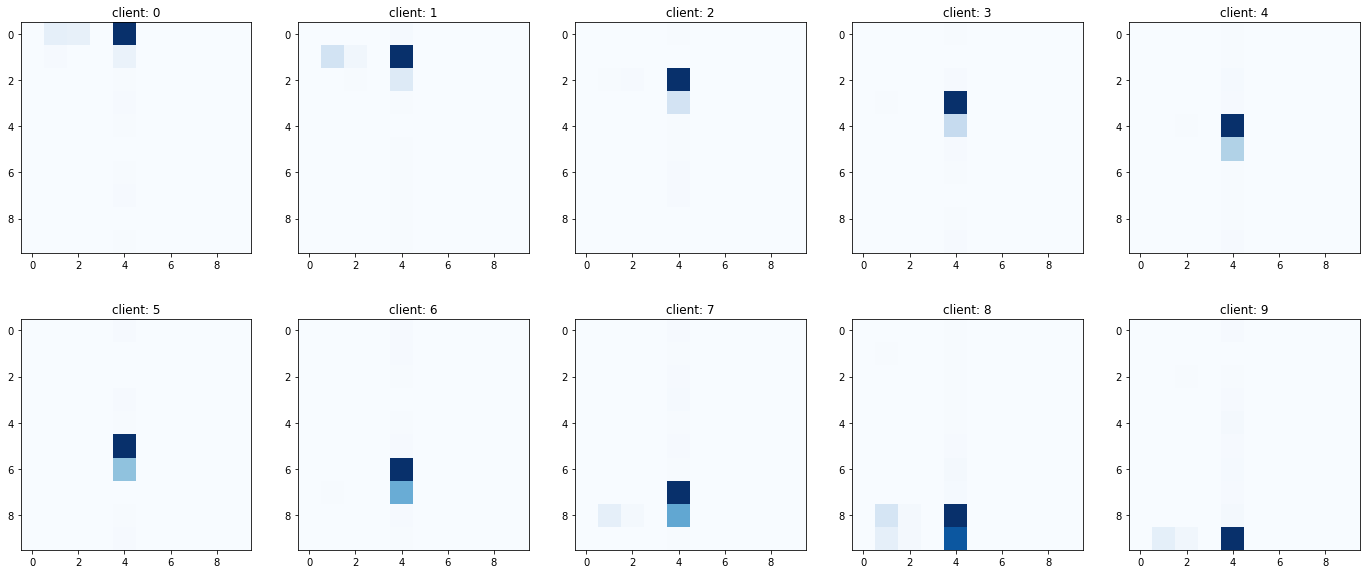

In [21]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    plt.imshow(client_evaluator_set[i].conf_mat, cmap='Blues')
    plt.title(f'client: {i}')


<BarContainer object of 10 artists>

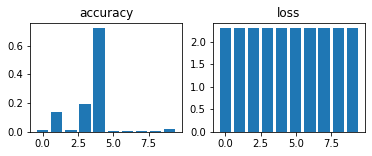

In [22]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].accuracy for i in range(n_clients)])
plt.title('accuracy')
fig.add_subplot(1, 2, 2)
plt.title('loss')   
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].loss for i in range(n_clients)])


In [23]:
global_evaluator.test()

global_evaluation: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


Text(0.5, 1.0, 'clieint average')

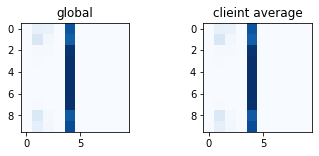

In [24]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.imshow(global_evaluator.conf_mat, cmap='Blues')
plt.title('global')
fig.add_subplot(1, 2, 2)
plt.imshow(avg_client_conf_mat, cmap='Blues')
plt.title('clieint average')


In [25]:
print('Global Accuracy', global_evaluator.accuracy, '\tClient avg Accuracy', avg_client_acc)
print('Global Loss' , global_evaluator.loss, '\tClient avg Loss', avg_client_loss)

Global Accuracy 0.11534633757961783 	Client avg Accuracy 0.11121753246753248
Global Loss 2.30258509299404 	Client avg Loss 2.302585092994046
